In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import json, ast, glob

# Analysis of hazard distributions

This code contains the main data analysis and visualizations of the initial work.

## Calculate hazard distributions from paths

Get the IDP-weighted probability of encountering each hazards over paths starting from each source settlement. 

Relies on already having the `out/<sim_name>_combined.json` (via `rw_source_diffusion.py` and `combine_diffusion_path_counts.py`) and `data/settlement_IDPs.txt` (via `extract_hazard_exposure_vectors.py`).

Saves to a new file `data/source_hazards_dist.csv`.

TODO: Maybe this section should be a separate script instead?

In [18]:
# Function for converting path string to tuple of node IDs
path_string_to_tuple = lambda x : tuple(int(n) for n in x.split('.'))

# Read output file (combined) for biased walks
data_file_biased = 'out/sim_output_source_diffusion_combined.json'
with open(data_file_biased, 'r') as f : data_biased_str = json.load(f)

# Convert keys to integers (TODO: could probably be done better)
data_biased = {}
for k, v in data_biased_str.items() :
    data_biased[int(k)] = v
del data_biased_str

In [19]:
# Import IDP data for settlements and list of hazards
settlement_IDPs = np.loadtxt('data/settlement_IDPs.txt', dtype=int)
hazard_list = ast.literal_eval(open('data/hazards_set.txt').read())

N = settlement_IDPs.shape[0]    # Index based on total number of settlements
source_agg_hazards = np.zeros((N, len(hazard_list)))
for source_id, path_counts in data_biased.items() :
    # Add number of IDPs as weight to hazard types encountered on all paths
    for path, c in path_counts.items() :
        path = path_string_to_tuple(path)
        for i, node in enumerate(path) :
            # Add number of IDPs as weight to hazard types encountered on all paths
            source_agg_hazards[source_id] += settlement_IDPs[node]

# TODO: With the above procedure, many rows will be zeros, and then many normalized rows will be NaNs. 
# If this is an issue, should decide where we want to deal with it

In [20]:
source_agg_hazards_norm = source_agg_hazards / source_agg_hazards.sum(axis=1, keepdims=True)

/var/folders/17/j4v928fn43lgly2gzf268j480000gn/T/ipykernel_69981/4035788377.py:1: RuntimeWarning: invalid value encountered in divide
  source_agg_hazards_norm = source_agg_hazards / source_agg_hazards.sum(axis=1, keepdims=True)


In [21]:
# pd.DataFrame(time_agg_hazards_norm, index=range(max_step), columns=hazard_list).to_csv('time_agg_hazards.csv')
source_hazards_dist = pd.DataFrame(source_agg_hazards_norm, index=range(source_agg_hazards_norm.shape[0]), columns=hazard_list)
source_hazards_dist

,Drought,Eviction,Conflict,Flood,Other
0,0.510929,0.122951,0.366120,0.000000,0.0
1,0.000000,0.000000,0.000000,1.000000,0.0
2,0.536364,0.000000,0.440909,0.022727,0.0
3,0.866667,0.000000,0.133333,0.000000,0.0
4,0.949640,0.050360,0.000000,0.000000,0.0
...,...,...,...,...,...
5669,1.000000,0.000000,0.000000,0.000000,0.0
5670,NaN,NaN,NaN,NaN,NaN
5671,0.000000,0.000000,1.000000,0.000000,0.0
5672,NaN,NaN,NaN,NaN,NaN


In [22]:
source_hazards_dist.to_csv('data/source_hazards_dist.csv')

## Visualizing hazard distributions

In [31]:
# TODO: import hazards set from data
hazards = ['Drought', 'Eviction', 'Conflict', 'Flood', 'Other']

In [32]:
hazard_colours = {
'Conflict':  "#F8766D",    
'Drought': "#A3A500",
'Eviction': "#00BF7D",
'Flood': "#00B0F6",
'Other': "#E76BF3"
}


#["#F8766D", "#A3A500", "#00BF7D", "#00B0F6", "#E76BF3"]

In [33]:
source_hazards_data = pd.read_csv('data/source_hazards_dist.csv', index_col=0)
source_hazards_data

,Drought,Eviction,Conflict,Flood,Other
0,0.510929,0.122951,0.366120,0.000000,0.0
1,0.000000,0.000000,0.000000,1.000000,0.0
2,0.536364,0.000000,0.440909,0.022727,0.0
3,0.866667,0.000000,0.133333,0.000000,0.0
4,0.949640,0.050360,0.000000,0.000000,0.0
...,...,...,...,...,...
5669,1.000000,0.000000,0.000000,0.000000,0.0
5670,NaN,NaN,NaN,NaN,NaN
5671,0.000000,0.000000,1.000000,0.000000,0.0
5672,NaN,NaN,NaN,NaN,NaN


In [34]:
data = source_hazards_data.stack().reset_index(name='probability').rename({'level_0': 'src_node', 'level_1': 'hazard'}, axis=1)
data

,src_node,hazard,probability
0,0,Drought,0.510929
1,0,Eviction,0.122951
2,0,Conflict,0.366120
3,0,Flood,0.000000
4,0,Other,0.000000
...,...,...,...
14455,5673,Drought,1.000000
14456,5673,Eviction,0.000000
14457,5673,Conflict,0.000000
14458,5673,Flood,0.000000


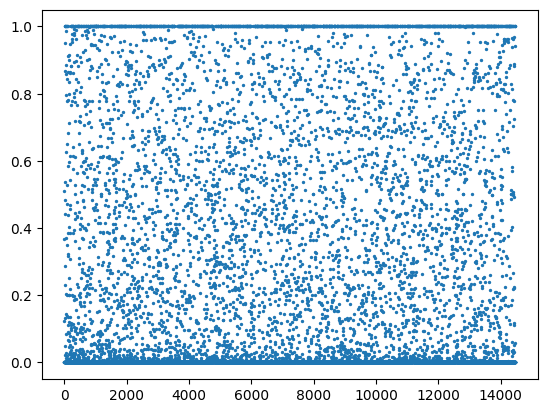

In [35]:
plt.scatter(range(data.shape[0]), data['probability'], s=2)

<timed exec>:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


CPU times: user 985 ms, sys: 31.8 ms, total: 1.02 s
Wall time: 474 ms


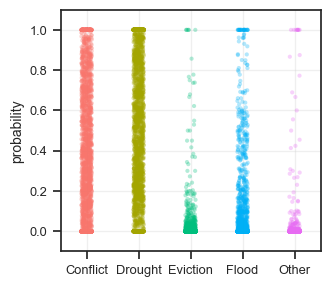

In [37]:
%%time

sns.set_theme(
    style='ticks',
    rc={'patch.edgecolor': 'none'},
    font='Arial',
    font_scale=.84
)

cm = 1/2.54 
fig, ax = plt.subplots(1, figsize=(8.1*cm, 7*cm), constrained_layout=True)

sns.stripplot(
    ax=ax, y='probability', x='hazard', data=data, orient='v', size=3, 
    legend=False, palette=sns.color_palette([hazard_colours[hazard] for hazard in sorted(hazards)], len(hazard_colours)),
    order=sorted(hazards), alpha=.3
)

ax.set_xlabel('')
ax.grid('on', alpha=.3)


ax.set_ylim(-.1, 1.1)

# fig.legend(handles=[
#     mpl.lines.Line2D([], [], color='w', marker='o', markerfacecolor='tab:blue', label='source point')]
# , bbox_to_anchor=(1,1.1))

#fig.suptitle('Which hazards are found along the path?')

# fig.savefig('figs/strip.pdf', dpi=300)
fig.savefig('figs/strip.png', dpi=600)

- Make color meaningful? — e.g. alpha or transparency or brightness depending on... path length?


## Sequence plot

Relies on `data/hazard_dist_time.csv` generated in `walk_statistics.ipynb`

In [38]:
hazards_data = pd.read_csv('data/hazards_dist_time_uniform.csv', index_col=0)
hazards_data

,Drought,Eviction,Conflict,Flood,Other
0,0.672430,0.017605,0.257466,0.037410,0.015090
1,0.884942,0.016347,0.087708,0.009117,0.001886
2,0.961019,0.002201,0.029236,0.007545,0.000000
3,0.968878,0.001257,0.023577,0.006287,0.000000
4,0.984282,0.000000,0.012260,0.003458,0.000000


In [39]:
cmap = mpl.colors.ListedColormap([hazard_colours[key] for key in hazards])

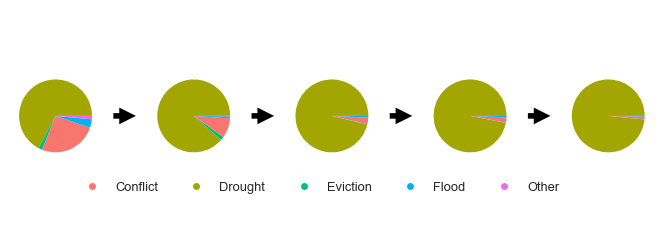

In [40]:
sns.set_theme(
    style='ticks',
    rc={'patch.edgecolor': 'none'},
    font='Arial',
    font_scale=.84
)

n_steps = hazards_data.shape[0]# 5
colours = cmap(np.arange(len(hazards)))


cm = 1/2.54 
fig, axs = plt.subplots(nrows=1, ncols=2*n_steps-1, figsize=(21.1*cm, 7*cm), width_ratios=(n_steps-1)*[.8,.2] + [.8])

for idx, ax in enumerate(axs.ravel()):
    if idx % 2 == 0:
        row_idx = int(idx / 2)
        ax.pie(hazards_data.loc[row_idx], colors=colours)
        #ax.set_title(f"XXX nodes finish\nat step {row_idx}")

    else: 
        ax.annotate('', xy=(1, .5), xytext=(0, .5),
            arrowprops=dict(facecolor='black', shrink=5e-3, lw=5e-3))    

    ax.axis('off')

fig.legend(handles=[mpl.lines.Line2D([], [], color='w', marker='o', markerfacecolor=hazard_colours[hazard], label=hazard) 
                    for hazard in sorted(hazards)], bbox_to_anchor=(.8,.3),  ncol=len(hazards), frameon=False)

# fig.savefig('../figs/pacman.pdf', dpi=300)